# Análisis Exploratorio de Datos (EDA) - OULAD Dataset

Este notebook tiene como objetivo comprender la estructura y características del dataset OULAD antes de proceder con modelados complejos.

## Objetivos
1. **Distribución de Clases**: ¿Está desbalanceado el dataset (Pass vs Fail vs Withdrawn)?
2. **Análisis Temporal**: ¿Cómo evoluciona la interacción de los estudiantes a lo largo de las semanas?
3. **Correlaciones Iniciales**: ¿Existe relación visible entre el número de clics y el resultado final?


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Rutas (Ajustar si es necesario)
DATA_DIR = Path("../data/processed")

# Cargar datos procesados
df_students = pd.read_csv(DATA_DIR / "students_processed.csv")
df_assessments = pd.read_csv(DATA_DIR / "assessments_processed.csv")
df_interactions = pd.read_csv(DATA_DIR / "interactions_processed.csv")

print("Datos cargados correctamente:")
print(f"Estudiantes: {df_students.shape}")
print(f"Evaluaciones: {df_assessments.shape}")
print(f"Interacciones: {df_interactions.shape}")

Datos cargados correctamente:
Estudiantes: (32593, 15)
Evaluaciones: (173912, 10)
Interacciones: (10655280, 9)


**Observaciones:** Podemos ver que tenemos un dataset relativamente grande con el que podemos entrenar adecuadamente nuestros modelos de inteligencia artificial y que puedan generalizar bien.

# Diccionario de Datos OULAD

A continuación se describe el contenido de las tablas generadas tras el preprocesamiento inicial del dataset OULAD.

### Tabla 1: Estudiantes (`students_processed.csv`)
Esta es la tabla maestra que contiene la información estática y demográfica de cada estudiante matriculado.

| Campo | Descripción |
| :--- | :--- |
| `code_module` | Identificador del curso (ej. AAA, BBB). |
| `code_presentation` | Semestre en el que se imparte (ej. 2013J, 2014B). |
| `id_student` | ID único anonimizado del estudiante. |
| `gender` | Género del estudiante (M/F). |
| `region` | Región geográfica de residencia en UK. |
| `highest_education` | Nivel educativo previo (ej. A Level, HE Qualification). |
| `imd_band` | Índice de privación múltiple (nivel socioeconómico de la zona, % más bajo = más pobreza). |
| `age_band` | Rango de edad (0-35, 35-55, 55<=). |
| `num_of_prev_attempts` | Número de veces que ha intentado este módulo antes. |
| `studied_credits` | Créditos totales que el estudiante está cursando actualmente. |
| `disability` | Si tiene discapacidad declarada (Y/N). |
| `final_result` | **Variable Objetivo**: Pass, Distinction, Fail, Withdrawn. |
| `date_registration` | Día relativo al inicio del curso en que se matriculó. |
| `date_unregistration` | Día relativo en que se dio de baja (si aplica). |

---

### Tabla 2: Evaluaciones (`assessments_processed.csv`)
Contiene los resultados de todos los exámenes y tareas puntuables.

| Campo | Descripción |
| :--- | :--- |
| `id_assessment` | ID de la prueba específica. |
| `id_student` | ID del estudiante. |
| `date_submitted` | Día relativo al inicio del curso en que el alumno entregó la tarea. |
| `is_banked` | Si la nota ha sido convalidada de una presentación anterior. |
| `score` | Nota obtenida (0-100). |
| `assessment_type` | Tipo de examen: TMA (Tutor Marked), CMA (Computer Marked), Exam. |
| `date` | Fecha límite de entrega oficial (Deadline). |
| `weight` | Peso de esta evaluación en la nota final del curso. |

---

### Tabla 3: Interacciones (`interactions_processed.csv`)
Es el log de actividad diario en el VLE (Virtual Learning Environment). Es la tabla más voluminosa.

| Campo | Descripción |
| :--- | :--- |
| `code_module` | Módulo visitado. |
| `id_student` | ID del estudiante. |
| `id_site` | ID del material específico visitado. |
| `date` | Día relativo al inicio del curso (puede ser negativo si accedió antes de que empezará). |
| `sum_click` | Número de clics realizados en ese material ese día. |
| `activity_type` | Tipo de recurso: `forumng` (foro), `oucontent` (contenido HTML), `resource` (PDF/Web), `quiz`, etc. |
| `week_from / week_to` | Semanas planificadas para ese material (muchos nulos). |



In [11]:
# Hacemos un display de las primeras filas para familiarizarnos con las columnas
print("--- DATOS DE ESTUDIANTES (Demográficos y Resultado) ---")
display(df_students.head(3))

print("\n--- DATOS DE EVALUACIONES (Notas) ---")
display(df_assessments.head(3))

print("\n--- DATOS DE INTERACCIONES (Clics en recursos) ---")
display(df_interactions.head(3))

# Verificamos si hay nulos
print("\n--- VALORES NULOS POR DATASET ---")
print("Estudiantes:", df_students.isnull().sum().sum())
print("Evaluaciones:", df_assessments.isnull().sum().sum())
print("Interacciones:", df_interactions.isnull().sum().sum())

--- DATOS DE ESTUDIANTES (Demográficos y Resultado) ---


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,268



--- DATOS DE EVALUACIONES (Notas) ---


,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0



--- DATOS DE INTERACCIONES (Clics en recursos) ---


,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,NaN,NaN
1,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
2,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN



--- VALORES NULOS POR DATASET ---
Estudiantes: 23677
Evaluaciones: 3038
Interacciones: 18539088


**Observaciones:** Dado que hemos visto datos nulos vamos a proceder a hacer una exploración para ver como tratarlos.

## 1. Distribución de la Variable Objetivo (final_result)
Es crucial saber si tenemos clases desbalanceadas, ya que esto afectará a las métricas del modelo futuro.

C:\Users\maike\AppData\Local\Temp\ipykernel_23304\2083810543.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


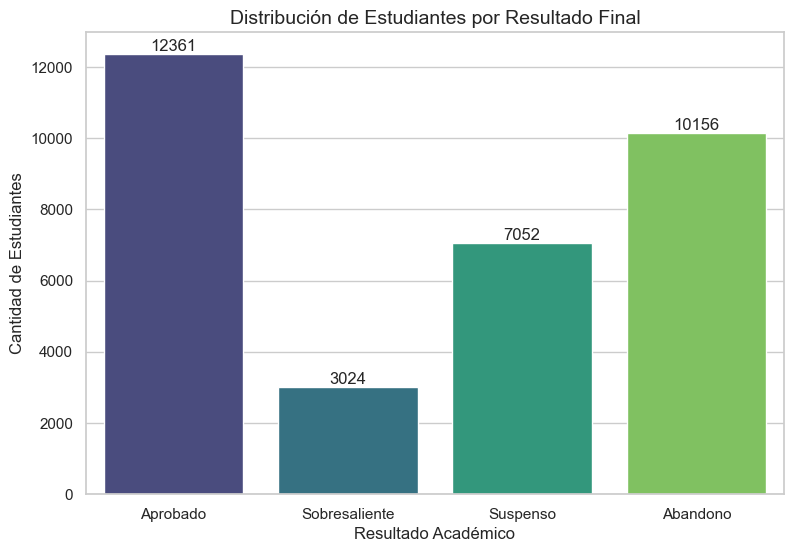

In [5]:
# Traducción de etiquetas para la gráfica
translation_map = {
    'Pass': 'Aprobado',
    'Distinction': 'Sobresaliente',
    'Fail': 'Suspenso',
    'Withdrawn': 'Abandono'
}

df_students['Resultado'] = df_students['final_result'].map(translation_map)

plt.figure(figsize=(9, 6))
ax = sns.countplot(
    data=df_students, 
    x='Resultado', 
    palette='viridis', 
    order=['Aprobado', 'Sobresaliente', 'Suspenso', 'Abandono']
)

# Añadir etiquetas de valor encima de las barras
for i in ax.containers:
    ax.bar_label(i)

plt.title("Distribución de Estudiantes por Resultado Final", fontsize=14)
plt.xlabel("Resultado Académico", fontsize=12)
plt.ylabel("Cantidad de Estudiantes", fontsize=12)
plt.show()

**Observaciones:** El análisis de la distribución de clases revela un escenario complejo que justifica la necesidad de modelos avanzados. Si planteamos el problema de forma binaria como "Persistencia" (Aprobado + Sobresaliente ≈ 15.3k) frente a "Riesgo" (Suspenso + Abandono ≈ 17.2k), el dataset se encuentra razonablemente balanceado, lo cual es ideal para el entrenamiento. Sin embargo, al desglosar el riesgo, observamos que el Abandono (10.1k) es significativamente más frecuente que el Suspenso académico (7k). Esta disparidad refuerza la hipótesis de que la deserción es el problema principal a atajar y sugiere que un modelo multiclasificador será más efectivo para distinguir entre quien se va prematuramente y quien falla por rendimiento.

## 2. Análisis Temporal de Interacciones

El dataset OULAD posee una naturaleza intrínsecamente secuencial que lo distingue de los conjuntos de datos estáticos tradicionales. Tanto las interacciones diarias en el VLE (date, sum_click) como las evaluaciones (date_submitted, score) se distribuyen a lo largo del tiempo, conformando la "huella digital" del aprendizaje de cada estudiante semana a semana. Esta estructura temporal es el fundamento ideal para la aplicación de arquitecturas basadas en Transformers. Al igual que estos modelos procesan palabras en una oración para entender el contexto, aquí procesaremos la secuencia de comportamientos semanales del alumno para predecir su trayectoria futura, permitiendo al sistema capturar dependencias a largo plazo (e.g., una baja actividad en la semana 2 que repercute en el examen de la semana 10) que modelos clásicos pasarían por alto.
Uno de los puntos clave de tu TFM es usar series temporales. Vamos a visualizar si realmente hay patrones temporales distintos entre los que aprueban y los que suspenden.

Para ello, necesitamos unir las interacciones con el resultado final del estudiante.

In [6]:
# Agrupamos clics por semana y estudiante
# Nota: 'date' en OULAD son días relativos al inicio del curso. Convertimos a semanas dividiendo por 7.

df_interactions['week'] = df_interactions['date'] // 7

# Sumamos clics por semana y estudiante-curso
weekly_activity = df_interactions.groupby(['code_module', 'code_presentation', 'id_student', 'week'])['sum_click'].sum().reset_index()

# Unimos con el resultado final (Target)
weekly_activity = pd.merge(
    weekly_activity, 
    df_students[['code_module', 'code_presentation', 'id_student', 'final_result']],
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# Aplicar traducción también aquí para la leyenda
weekly_activity['Resultado'] = weekly_activity['final_result'].map(translation_map)

# Filtramos semanas negativas (pre-curso) y muy lejanas para limpiar la visualización
weekly_activity = weekly_activity[(weekly_activity['week'] >= 0) & (weekly_activity['week'] <= 40)]

print(weekly_activity.head())

  code_module code_presentation  id_student  week  sum_click final_result  \
1         AAA             2013J       11391     0        183         Pass   
2         AAA             2013J       11391     1         20         Pass   
3         AAA             2013J       11391     2        100         Pass   
4         AAA             2013J       11391     4         26         Pass   
5         AAA             2013J       11391     5         60         Pass   

  Resultado  
1  Aprobado  
2  Aprobado  
3  Aprobado  
4  Aprobado  
5  Aprobado  


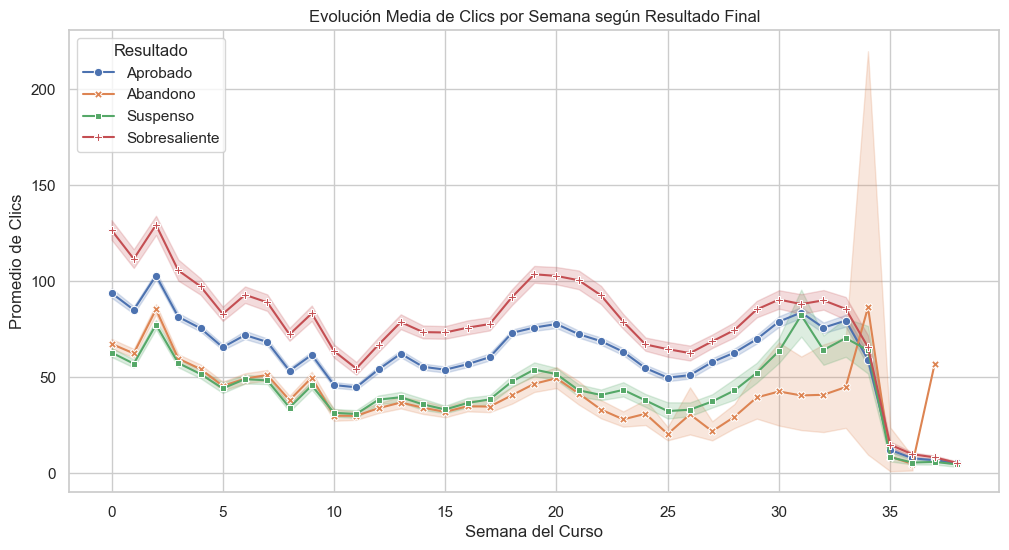

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_activity, x='week', y='sum_click', hue='Resultado', style='Resultado', markers=True, dashes=False)
plt.title("Evolución Media de Clics por Semana según Resultado Final")
plt.xlabel("Semana del Curso")
plt.ylabel("Promedio de Clics")
plt.legend(title='Resultado')
plt.show()

### Interpretación Esperada
Deberíamos ver que los estudiantes 'Withdrawn' (Abandonos) tienen una caída drástica de actividad en algún punto, mientras que 'Pass' y 'Distinction' mantienen picos de actividad, probablemente coincidentes con las fechas de exámenes.

## 3. Correlación: Clics Totales vs Nota Media
¿Estudiar más (más clics) garantiza mejor nota?

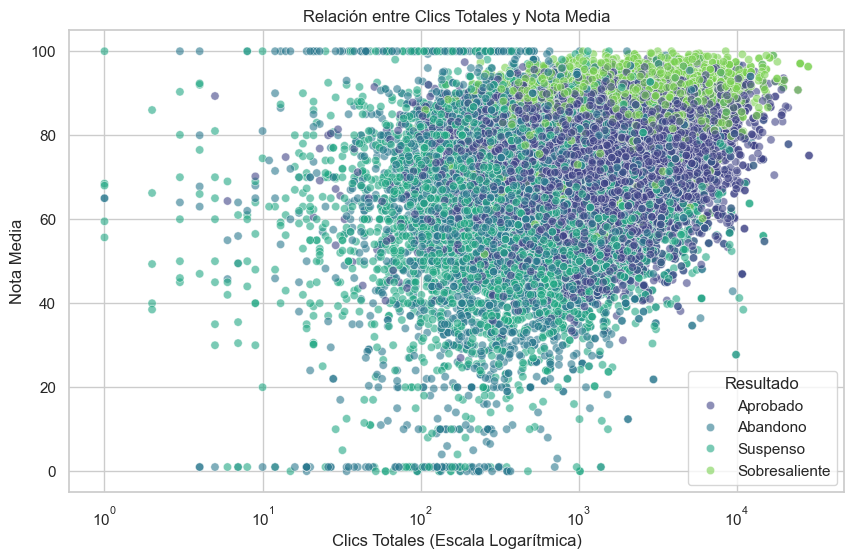

In [12]:
# Calculamos clics totales por estudiante
total_clicks = df_interactions.groupby('id_student')['sum_click'].sum().reset_index()
total_clicks.rename(columns={'sum_click': 'total_clicks'}, inplace=True)

# Calculamos nota media por estudiante (en evaluaciones puntuables)
avg_score = df_assessments.groupby('id_student')['score'].mean().reset_index()
avg_score.rename(columns={'score': 'mean_score'}, inplace=True)

# Unimos
analysis_df = pd.merge(total_clicks, avg_score, on='id_student')
analysis_df = pd.merge(analysis_df, df_students[['id_student', 'final_result']], on='id_student')

# Traducción para visualización
analysis_df['Resultado'] = analysis_df['final_result'].map(translation_map)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_df, x='total_clicks', y='mean_score', hue='Resultado', alpha=0.6, palette='viridis')
plt.title("Relación entre Clics Totales y Nota Media")
plt.xscale('log') # Escala logarítmica porque suele haber outliers con muchísimos clics
plt.xlabel("Clics Totales (Escala Logarítmica)")
plt.ylabel("Nota Media")
plt.show()